# A* Search Algorithm

A* is the best pathfinding algorithm for most real-world problems. It's Dijkstra with a heuristic that guides it toward the goal.

## The Problem with Dijkstra

Dijkstra explores equally in all directions. If the goal is east, Dijkstra still wastes time exploring west.

**A Star solution:** Use a heuristic to estimate distance to goal. Prioritize nodes that seem closer to the goal.

## The A* Formula

For each node, A* calculates:

**f(n) = g(n) + h(n)**

- **g(n)** = Actual cost from start to node n (like Dijkstra)
- **h(n)** = Estimated cost from node n to goal (heuristic)
- **f(n)** = Total estimated cost of path through n

Always expand the node with the lowest f(n).

## Simple Example

```
Start at A, goal at D
Distance from A to B = 1
Distance from B to C = 1  
Distance from C to D = 1

Using Manhattan distance heuristic:
h(A) = 3 (3 steps to D)
h(B) = 2
h(C) = 1

At start: 
  Node A: f(A) = g(A) + h(A) = 0 + 3 = 3

After moving to B:
  Node B: f(B) = g(B) + h(B) = 1 + 2 = 3
  Node X (wrong direction): f(X) = g(X) + h(X) = 1 + 4 = 5

A* picks B over X because f(B) < f(X)
```

The heuristic guides the search toward the goal.

In [1]:
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict
from IPython.display import clear_output
import time

%matplotlib inline

In [2]:
class GridWorld:
    """2D grid with obstacles"""
    def __init__(self, width, height, obstacles, start, goal):
        self.width = width
        self.height = height
        self.obstacles = set(obstacles)
        self.start = start
        self.goal = goal
    
    def neighbors(self, pos):
        """Get valid neighboring positions (4-directional)"""
        x, y = pos
        candidates = [
            (x+1, y), (x-1, y),  # right, left
            (x, y+1), (x, y-1)   # up, down
        ]
        return [
            (nx, ny) for nx, ny in candidates
            if 0 <= nx < self.width and 0 <= ny < self.height
            and (nx, ny) not in self.obstacles
        ]
    
    def cost(self, from_pos, to_pos):
        """Cost to move between adjacent cells"""
        return 1
    
    def heuristic(self, pos):
        """Manhattan distance to goal"""
        return abs(pos[0] - self.goal[0]) + abs(pos[1] - self.goal[1])

print("Grid world created")

Grid world created


## Understanding Heuristics

A heuristic is an estimate of remaining cost. For A* to guarantee the shortest path, the heuristic must be **admissible** - never overestimate.

**Manhattan distance** (for grid movement):
```
h(n) = |n.x - goal.x| + |n.y - goal.y|
```

This counts the minimum steps needed if there were no obstacles. Always admissible.

**Why admissible matters:**
- If h(n) underestimates, A* still finds optimal path (just explores more)
- If h(n) overestimates, A* might miss the optimal path
- If h(n) = 0, A* becomes Dijkstra

**Example:**
```
Current: (2, 3), Goal: (5, 7)
h = |5-2| + |7-3| = 3 + 4 = 7

This is admissible: you need AT LEAST 7 steps.
You might need more (obstacles), but never less.
```

In [3]:
def a_star(grid):
    """
    A* algorithm implementation
    Returns: path, visited nodes, and search tree for visualization
    """
    # Priority queue: (f_score, counter, position)
    # counter ensures consistent ordering when f_scores are equal
    open_set = []
    counter = 0
    heapq.heappush(open_set, (0, counter, grid.start))
    counter += 1
    
    # Track where we came from
    came_from = {}
    
    # g_score: cost from start to node
    g_score = defaultdict(lambda: float('inf'))
    g_score[grid.start] = 0
    
    # f_score: g_score + heuristic
    f_score = defaultdict(lambda: float('inf'))
    f_score[grid.start] = grid.heuristic(grid.start)
    
    visited = []
    
    while open_set:
        current_f, _, current = heapq.heappop(open_set)
        visited.append(current)
        
        if current == grid.goal:
            # Reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], visited
        
        for neighbor in grid.neighbors(current):
            tentative_g = g_score[current] + grid.cost(current, neighbor)
            
            if tentative_g < g_score[neighbor]:
                # This path to neighbor is better
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + grid.heuristic(neighbor)
                heapq.heappush(open_set, (f_score[neighbor], counter, neighbor))
                counter += 1
    
    return None, visited  # No path found

print("A* implementation ready")

A* implementation ready


## A* Algorithm Step by Step

**Setup:**
```python
open_set = [(0, start)]  # Priority queue: (f_score, node)
g_score = {start: 0}     # Cost from start to each node
f_score = {start: h(start)}  # g + h for each node
came_from = {}           # Parent tracking for path reconstruction
```

**Main Loop:**

**Step 1:** Get node with lowest f_score
```python
current = heappop(open_set)  # Node that looks most promising
```

**Step 2:** Check if done
```python
if current == goal:
    return reconstruct_path()
```

**Step 3:** For each neighbor, calculate costs
```python
for neighbor in neighbors(current):
    tentative_g = g_score[current] + cost(current, neighbor)
    
    if tentative_g < g_score[neighbor]:  # Found better path
        g_score[neighbor] = tentative_g
        f_score[neighbor] = tentative_g + heuristic(neighbor)
        heappush(open_set, (f_score[neighbor], neighbor))
        came_from[neighbor] = current
```

**Step 4:** Repeat until goal found

## Example Walkthrough

```
Grid:
S . . .
. X X .
. X . G

Step 1:
  Open: [(3, S)]  (f=0+3=3)
  Expand S, add neighbors

Step 2:
  Open: [(4, (1,0)), (5, (0,1))]
  (1,0) has f=1+3=4, (0,1) has f=1+4=5
  Pick (1,0)

Step 3:
  Open: [(5, (0,1)), (5, (2,0))]
  Both have f=5, pick either
  Continue...

Step 4:
  Eventually reach G with optimal path
```

Notice how A* prefers nodes with lower f_score - nodes that seem closer to the goal.

In [4]:
def visualize_search(grid, path, visited):
    """Visualize the grid, obstacles, path, and visited nodes"""
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, grid.width)
    ax.set_ylim(0, grid.height)
    ax.set_aspect('equal')
    
    # Draw grid
    for x in range(grid.width):
        for y in range(grid.height):
            color = 'white'
            alpha = 1.0
            
            if (x, y) in grid.obstacles:
                color = 'black'
            elif (x, y) in visited:
                color = 'lightblue'
                alpha = 0.5
            
            rect = patches.Rectangle((x, y), 1, 1, 
                                     linewidth=1, edgecolor='gray',
                                     facecolor=color, alpha=alpha)
            ax.add_patch(rect)
    
    # Draw path
    if path:
        for i in range(len(path) - 1):
            x1, y1 = path[i]
            x2, y2 = path[i+1]
            ax.arrow(x1+0.5, y1+0.5, x2-x1, y2-y1,
                    head_width=0.2, head_length=0.2,
                    fc='red', ec='red', linewidth=2, length_includes_head=True)
        
        # Highlight path cells
        for x, y in path[1:-1]:
            rect = patches.Rectangle((x, y), 1, 1,
                                     linewidth=2, edgecolor='red',
                                     facecolor='yellow', alpha=0.6)
            ax.add_patch(rect)
    
    # Mark start and goal
    start_x, start_y = grid.start
    goal_x, goal_y = grid.goal
    
    ax.text(start_x+0.5, start_y+0.5, 'S', ha='center', va='center',
           fontsize=20, fontweight='bold', color='green')
    ax.text(goal_x+0.5, goal_y+0.5, 'G', ha='center', va='center',
           fontsize=20, fontweight='bold', color='red')
    
    ax.set_xticks(range(grid.width))
    ax.set_yticks(range(grid.height))
    ax.grid(True, alpha=0.3)
    
    if path:
        ax.set_title(f'A* Path Found | Length: {len(path)} | Nodes Explored: {len(visited)}',
                    fontsize=14, fontweight='bold')
    else:
        ax.set_title('No Path Found', fontsize=14, fontweight='bold', color='red')
    
    plt.tight_layout()
    plt.show()

print("Visualization ready")

Visualization ready


## Example: Simple Maze

Watch A* navigate around obstacles using Manhattan distance heuristic.

Running A*...
Path found! Length: 21
Nodes explored: 58


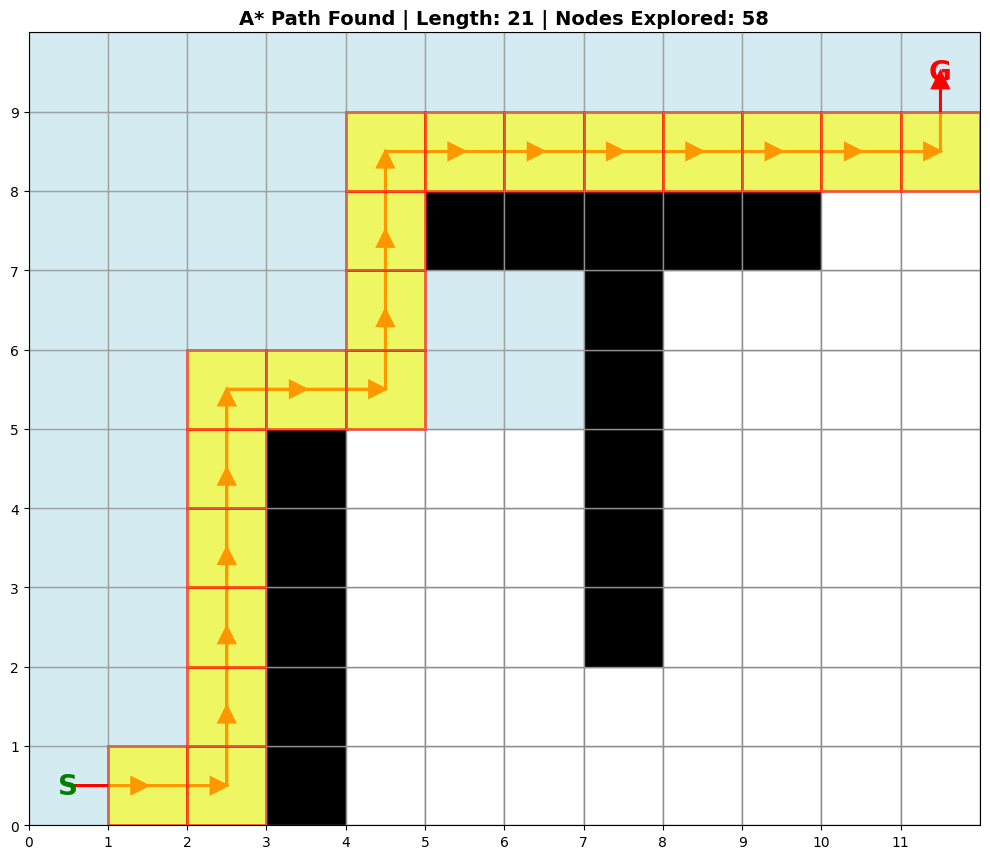

In [5]:
# Create a maze
obstacles = [
    (3, 0), (3, 1), (3, 2), (3, 3), (3, 4),
    (7, 2), (7, 3), (7, 4), (7, 5), (7, 6),
    (5, 7), (6, 7), (7, 7), (8, 7), (9, 7)
]

grid = GridWorld(
    width=12,
    height=10,
    obstacles=obstacles,
    start=(0, 0),
    goal=(11, 9)
)

print("Running A*...")
path, visited = a_star(grid)

if path:
    print(f"Path found! Length: {len(path)}")
    print(f"Nodes explored: {len(visited)}")
else:
    print("No path exists!")

visualize_search(grid, path, visited)

## Why A* Works

Look at the blue explored nodes. Notice how they cluster toward the goal?

**A* focuses search in the promising direction.**

Compare to Dijkstra (which explores everywhere equally) or BFS (which explores by distance only).

**The heuristic acts like a compass** - pointing the search toward the goal while g(n) ensures we don't ignore cheaper paths.

### The Key Insight

**Dijkstra:** "What's the cheapest node to expand?" (explores uniformly)

**A Star:** "What's the cheapest node to expand that also looks close to the goal?" (explores strategically)

A* explores fewer nodes because it doesn't waste time on nodes far from the goal.

## Compare Different Scenarios

Open space:
Path length: 19, Nodes explored: 100


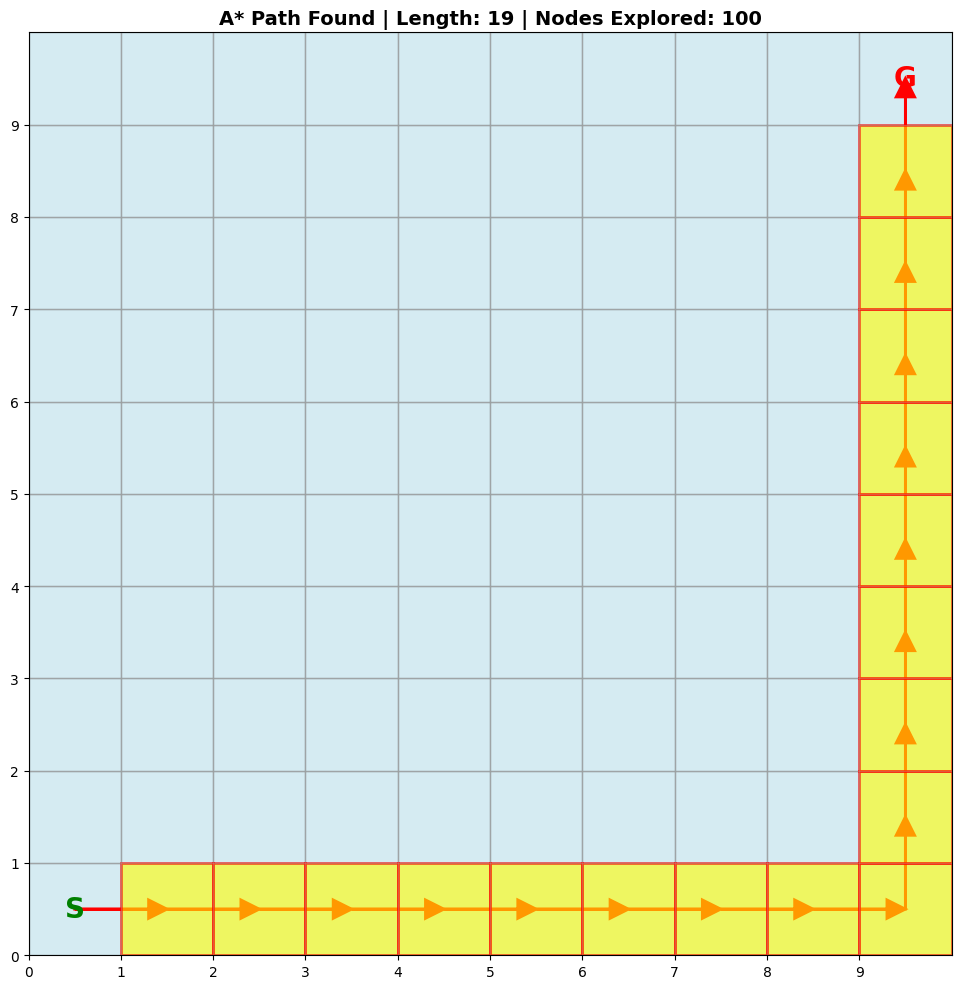

In [6]:
# Scenario 1: Wide open space
grid1 = GridWorld(10, 10, [], (0, 0), (9, 9))
path1, visited1 = a_star(grid1)
print("Open space:")
print(f"Path length: {len(path1)}, Nodes explored: {len(visited1)}")
visualize_search(grid1, path1, visited1)

Long barrier:
Path length: 20, Nodes explored: 76


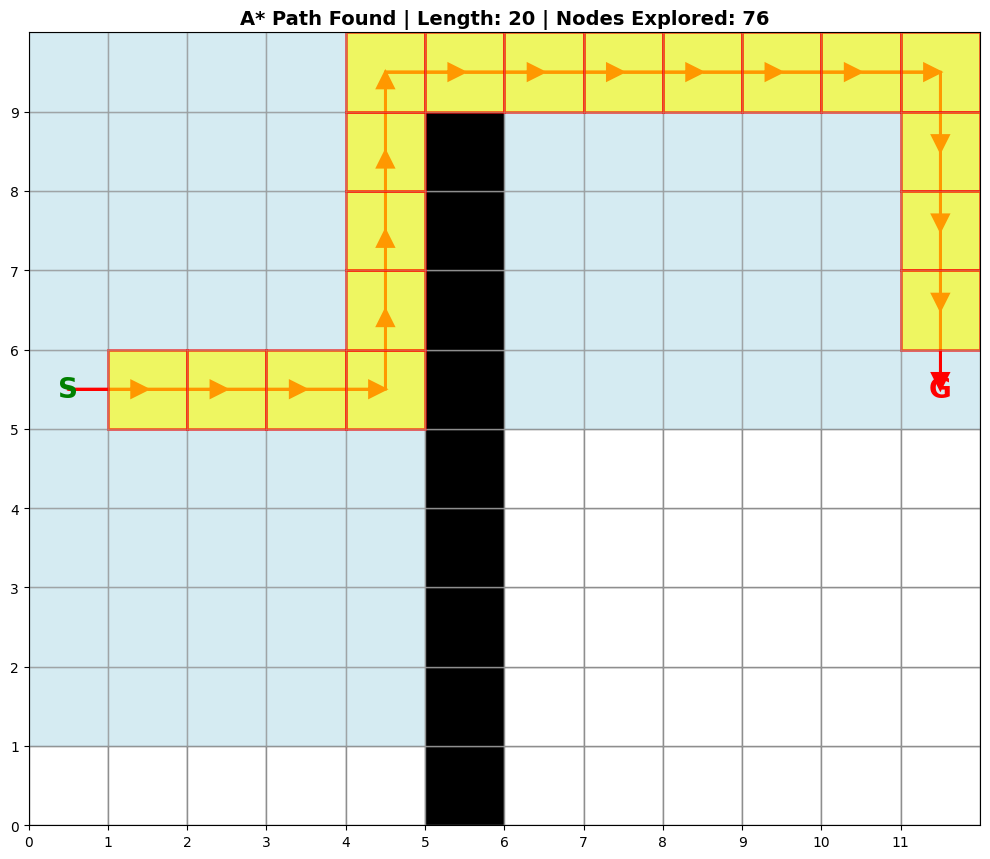

In [7]:
# Scenario 2: Must go around barrier
barrier = [(5, i) for i in range(9)]
grid2 = GridWorld(12, 10, barrier, (0, 5), (11, 5))
path2, visited2 = a_star(grid2)
print("Long barrier:")
print(f"Path length: {len(path2)}, Nodes explored: {len(visited2)}")
visualize_search(grid2, path2, visited2)

## Key Takeaways

**When to use A*:**
- Need the shortest path
- Have a good heuristic function
- Can afford the memory (stores all candidate nodes)

**Admissible heuristic:**
- Never overestimates true cost
- Manhattan distance is admissible for grid movement
- Euclidean distance also works
- h(n) = 0 reduces A* to Dijkstra

**Time complexity:** O(b^d) where b is branching factor, d is solution depth  
**Space complexity:** O(b^d) - stores all frontier nodes